In [36]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

In [5]:
# Caricamento del dataset
FFILE = "data/WELFake_Dataset.csv"

if os.path.isfile(FFILE):
    print("File already exists")
    if os.access(FFILE, os.R_OK):
        print ("File is readable")
    else:
        print ("File is not readable")
else:
    print("Either the file is missing or not readable, download it")

File already exists
File is readable


In [37]:
# Lettura e analisi preliminare
df = pd.read_csv(FFILE)

print("Prime righe del dataset:\n", df.head())
print("\nColonne disponibili:", df.columns.tolist())
print("\nInfo sul dataset:\n")

Prime righe del dataset:
    Unnamed: 0                                              title  \
0           0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1           1                                                NaN   
2           2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3           3  Bobby Jindal, raised Hindu, uses story of Chri...   
4           4  SATAN 2: Russia unvelis an image of its terrif...   

                                                text  label  
0  No comment is expected from Barack Obama Membe...      1  
1     Did they post their votes for Hillary already?      1  
2   Now, most of the demonstrators gathered last ...      1  
3  A dozen politically active pastors came here f...      0  
4  The RS-28 Sarmat missile, dubbed Satan 2, will...      1  

Colonne disponibili: ['Unnamed: 0', 'title', 'text', 'label']

Info sul dataset:




Distribuzione classi:
 label
0    34790
1    28329
Name: count, dtype: int64


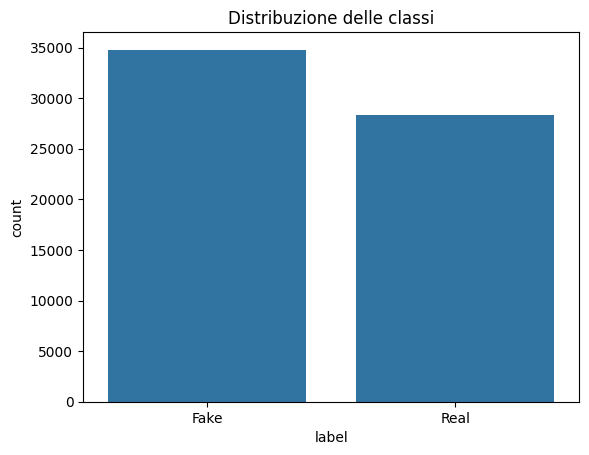

In [ ]:
# Pulizia dati iniziale

# Teniamo solo le colonne rilevanti
df = df[['title', 'text', 'label']]

# Rimuove righe con valori mancanti
df = df.dropna()

# Unisce il titolo con il testo per formare una rappresentazione più ricca
df['full_text'] = df['title'].str.strip() + ". " + df['text'].str.strip()

# Converte le etichette (se non sono già int)
df['label'] = df['label'].astype(int)

# Elimina eventuali duplicati
df = df.drop_duplicates(subset='full_text')

# Distribuzione delle classi (Fake = 0, Real = 1)
print("\nDistribuzione classi:\n", df['label'].value_counts())

# Visualizzazione distribuzione classi
sns.countplot(x='label', data=df)
plt.title("Distribuzione delle classi")
plt.xticks([0, 1], ['Fake', 'Real'])
plt.show()


In [8]:
# Funzione di pulizia del testo
def clean_text(text):
    # Trasforma tutto in minuscolo
    text = text.lower()

    # Rimuove spazi multipli, tabulazioni e ritorni a capo
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Applica la pulizia al testo combinato
df['clean_text'] = df['full_text'].apply(clean_text)

In [ ]:
# Trasformazione da testo a numeri (TF-IDF)

# Serve per rappresentare il testo in forma numerica, pesando le parole in base a quanto sono "informative"
# (cioè comuni nel documento ma non troppo comuni ovunque)


# Calcola TF-IDF con uni-grammi e bi-grammi
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1,2))

# Applica la trasformazione al testo pulito
X = vectorizer.fit_transform(df['clean_text'])

# Target (0 = fake, 1 = real)
y = df['label'].values

In [ ]:
# Split Train/Test

# Suddivide in training e test set (80% / 20%)
# stratify=y per mantenere la stessa proporzione di etichette (fake/real) nei due insiemi
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, df.index, test_size=0.2, stratify=y, random_state=42
)

print(f"Train size: {X_train.shape[0]} - Test size: {X_test.shape[0]}")


Train size: 50495 - Test size: 12624


Accuracy: 0.9466

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      6958
           1       0.94      0.94      0.94      5666

    accuracy                           0.95     12624
   macro avg       0.95      0.95      0.95     12624
weighted avg       0.95      0.95      0.95     12624


Confusion Matrix:
 [[6628  330]
 [ 344 5322]]


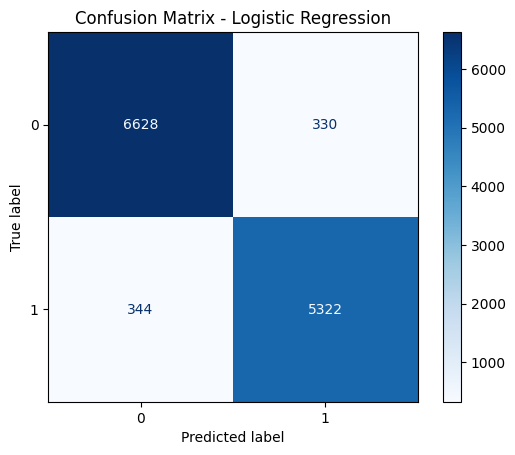

In [ ]:
"""
Modello di regressione logistica
"""
model = LogisticRegression(solver='liblinear', max_iter=100)

# Allena il modello sui dati di training
model.fit(X_train, y_train)

# Previsione sul test set
y_pred_logreg = model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred_logreg)
print(f"Accuracy: {accuracy:.4f}")

# Report con precision, recall, f1-score per ogni classe
print("\nClassification Report:\n", classification_report(y_test, y_pred_logreg))

# Matrice di confusione per vedere i falsi positivi e negativi
conf_matrix = confusion_matrix(y_test, y_pred_logreg)
print("\nConfusion Matrix:\n", conf_matrix)

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.grid(False)
plt.show()


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Migliori parametri trovati: {'C': 1, 'penalty': 'l1'}
Migliore accuratezza in CV: 0.9506287751262501
Accuratezza sul test set: 0.9531
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      6958
           1       0.95      0.95      0.95      5666

    accuracy                           0.95     12624
   macro avg       0.95      0.95      0.95     12624
weighted avg       0.95      0.95      0.95     12624


--- VALIDAZIONE INCROCIATA (Logistic Regression GridSearch) ---
Accuratezza media (5-fold CV): 0.9523
Deviazione standard: 0.0035


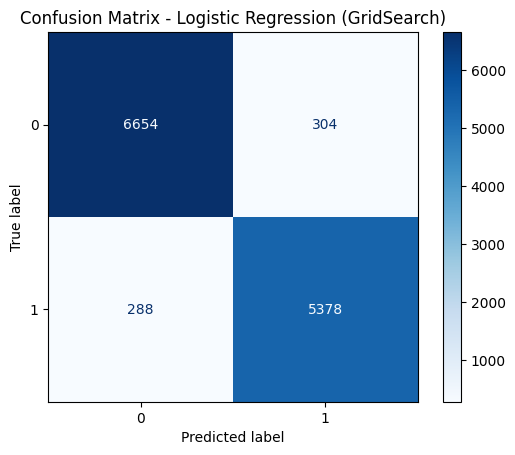

In [ ]:
"""
Modello di regressione logistica (GridSearch)
"""

logreg = LogisticRegression(max_iter=100, solver='liblinear')

# Definiamo la griglia di parametri da testare
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],      # valori di regolarizzazione
    'penalty': ['l1', 'l2']            # tipo di regolarizzazione
}

grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring='accuracy',    
    cv=5,                  # numero di fold
    verbose=2,             # stampa il progresso
    n_jobs=-1              # usa tutti i core del processore per velocizzare
)

# Ricerca sul training set
grid_search.fit(X_train, y_train)

# Migliori parametri trovati
print("Migliori parametri trovati:", grid_search.best_params_)

# Miglior score in validazione
print("Migliore accuratezza in CV:", grid_search.best_score_)

# Valuta il modello migliore sul test set
best_model = grid_search.best_estimator_
y_pred_logreg_grid = best_model.predict(X_test)

print(f"Accuratezza sul test set: {accuracy_score(y_test, y_pred_logreg_grid):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_logreg_grid))

# Valutazione con 5-fold cross-validation su tutto il dataset
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')

print("\n--- VALIDAZIONE INCROCIATA (Logistic Regression GridSearch) ---")
print(f"Accuratezza media (5-fold CV): {cv_scores.mean():.4f}")
print(f"Deviazione standard: {cv_scores.std():.4f}")

ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression (GridSearch)")
plt.grid(False)
plt.show()


SVM Lineare - Accuracy: 0.9501742712294043
Classification Report SVM Lineare:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95      6958
           1       0.94      0.95      0.94      5666

    accuracy                           0.95     12624
   macro avg       0.95      0.95      0.95     12624
weighted avg       0.95      0.95      0.95     12624



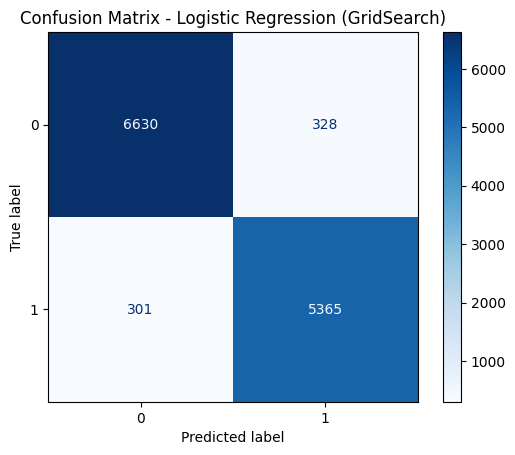

In [17]:
"""
Modello SVM lineare
"""
svm_linear = LinearSVC(random_state=0, max_iter=5000)
svm_linear.fit(X_train, y_train)

# Predizione
y_pred_linear = svm_linear.predict(X_test)

# Valutazione
print("SVM Lineare - Accuracy:", accuracy_score(y_test, y_pred_linear))
print("Classification Report SVM Lineare:\n", classification_report(y_test, y_pred_linear))

ConfusionMatrixDisplay.from_estimator(svm_linear, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression (GridSearch)")
plt.grid(False)
plt.show()


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Migliori parametri trovati: {'C': 1, 'dual': False, 'penalty': 'l2'}
Accuratezza sul test set con parametri ottimizzati: 0.9502
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      6958
           1       0.94      0.95      0.94      5666

    accuracy                           0.95     12624
   macro avg       0.95      0.95      0.95     12624
weighted avg       0.95      0.95      0.95     12624

Accuracy media CV: 0.9510, std: 0.0020


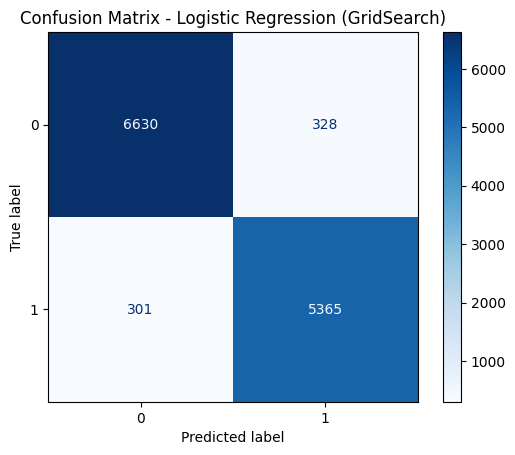

In [ ]:
"""
Modello SVM con Grid Search
"""
svm = LinearSVC(random_state=0, max_iter=5000)

param_grid = {
    'C': [0.01, 0.1, 1, 10],   
    'penalty': ['l2'],         
    'dual': [False]            
}

# GridSearch con 5 fold cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=5, n_jobs=-1, verbose=2)

# Esegue il fitting
grid_search.fit(X_train, y_train)

# Migliori parametri
print("Migliori parametri trovati:", grid_search.best_params_)

# Valutazione sul test set
y_pred_svm_grid = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_svm_grid)
print(f"Accuratezza sul test set con parametri ottimizzati: {accuracy:.4f}")

print(classification_report(y_test, y_pred_svm_grid))

best_svm = grid_search.best_estimator_
cv_scores = cross_val_score(best_svm, X, y, cv=5, scoring='accuracy')
print(f"Accuracy media CV: {cv_scores.mean():.4f}, std: {cv_scores.std():.4f}")

ConfusionMatrixDisplay.from_estimator(best_svm, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression (GridSearch)")
plt.grid(False)
plt.show()


In [35]:
"""# 2. Trova gli indici degli errori
falsi_positivi_idx = np.where((y_pred_svm_grid == 1) & (y_test == 0))[0]  # Fake predetti come Real
falsi_negativi_idx = np.where((y_pred_svm_grid == 0) & (y_test == 1))[0]  # Real predetti come Fake

# 3. Per stampare i testi originali, serve ricavare gli indici dei campioni originali.
# Poiché X_test è sparsa, e abbiamo usato train_test_split senza shuffle, puoi prendere l'indice da X_test con:
# ATTENZIONE: se hai fatto shuffle, questa cosa cambia. Qui assumiamo che y_test e X_test siano allineati.

print("Esempi di falsi positivi (Fake predetti come Real):")
for i in falsi_positivi_idx[:10]:  # mostra i primi 5 esempi
    #print(f"Testo: {df.iloc[X_test.indices[i]]['clean_text']}")
    print(f"Etichetta vera: 0, Predizione: 1")
    print("---")

print("\nEsempi di falsi negativi (Real predetti come Fake):")
for i in falsi_negativi_idx[:5]:  # mostra i primi 5 esempi
    #print(f"Testo: {df.iloc[X_test.indices[i]]['clean_text']}")
    print(f"Etichetta vera: 1, Predizione: 0")
    print("---")"""


'# 2. Trova gli indici degli errori\nfalsi_positivi_idx = np.where((y_pred_svm_grid == 1) & (y_test == 0))[0]  # Fake predetti come Real\nfalsi_negativi_idx = np.where((y_pred_svm_grid == 0) & (y_test == 1))[0]  # Real predetti come Fake\n\n# 3. Per stampare i testi originali, serve ricavare gli indici dei campioni originali.\n# Poiché X_test è sparsa, e abbiamo usato train_test_split senza shuffle, puoi prendere l\'indice da X_test con:\n# ATTENZIONE: se hai fatto shuffle, questa cosa cambia. Qui assumiamo che y_test e X_test siano allineati.\n\nprint("Esempi di falsi positivi (Fake predetti come Real):")\nfor i in falsi_positivi_idx[:10]:  # mostra i primi 5 esempi\n    #print(f"Testo: {df.iloc[X_test.indices[i]][\'clean_text\']}")\n    print(f"Etichetta vera: 0, Predizione: 1")\n    print("---")\n\nprint("\nEsempi di falsi negativi (Real predetti come Fake):")\nfor i in falsi_negativi_idx[:5]:  # mostra i primi 5 esempi\n    #print(f"Testo: {df.iloc[X_test.indices[i]][\'clean_text\'

Random Forest Accuracy: 0.9428

Classification Report Random Forest:
               precision    recall  f1-score   support

           0       0.94      0.95      0.95      6958
           1       0.94      0.93      0.94      5666

    accuracy                           0.94     12624
   macro avg       0.94      0.94      0.94     12624
weighted avg       0.94      0.94      0.94     12624



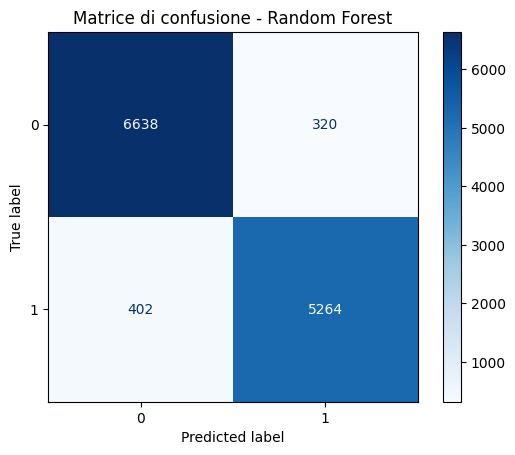

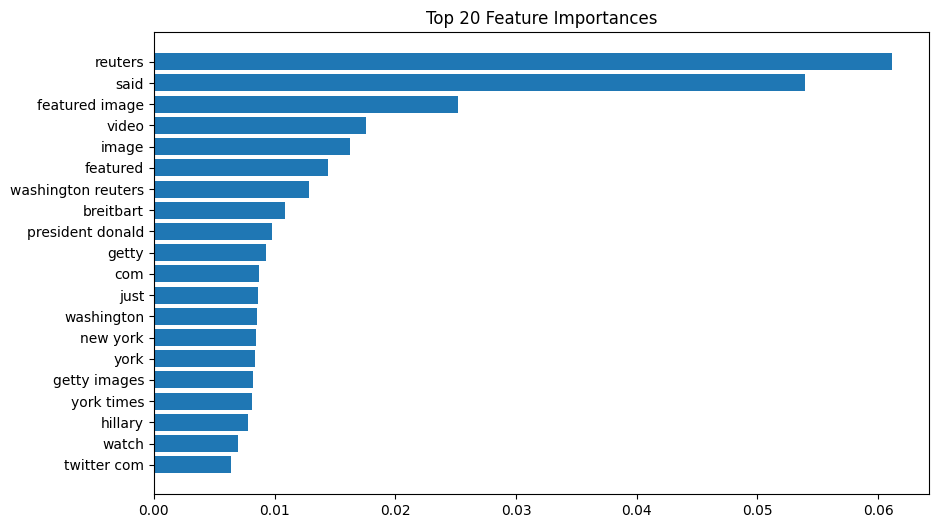

In [ ]:
"""
Modello Random Forest
"""
rf_model = RandomForestClassifier(n_estimators=100, random_state=0) # n_estimators = numero di alberi nella foresta (es. 100)

# Allena il modello sui dati di training (TF-IDF + label)
rf_model.fit(X_train, y_train)

# Predice le etichette sul test set
y_pred_rf_base = rf_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf_base)
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")

# Report di classificazione (precision, recall, f1-score)
print("\nClassification Report Random Forest:\n", classification_report(y_test, y_pred_rf_base))

ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test, cmap='Blues')
plt.title("Matrice di confusione - Random Forest")
plt.grid(False)
plt.show()

# Importanza delle feature
importances = rf_model.feature_importances_
# Prendi le prime 20 feature più importanti per visualizzare
indices = importances.argsort()[-20:][::-1]
features = np.array(vectorizer.get_feature_names_out())

plt.figure(figsize=(10,6))
plt.title("Top 20 Feature Importances")
plt.barh(range(20), importances[indices], align='center')
plt.yticks(range(20), features[indices])
plt.gca().invert_yaxis()
plt.show()


In [ ]:
"""
Modelllo Random forest con randomized search
"""
# Random Forest base
rf = RandomForestClassifier(random_state=0, n_jobs=-1)

param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

random_search_rf = RandomizedSearchCV(
    rf, param_distributions=param_dist, 
    n_iter=12, cv=4, n_jobs=-1, verbose=2, random_state=0
)

random_search_rf.fit(X_train, y_train)

print("Migliori parametri RF:", random_search_rf.best_params_)

y_pred_rf = random_search_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuratezza RF ottimizzata: {accuracy_rf:.4f}")

# Valutazione con 5-fold cross-validation su tutto il dataset (X, y)
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')

print("\n--- VALIDAZIONE INCROCIATA (Random Forest RandomizedSearch) ---")
print(f"Accuratezza media (5-fold CV): {cv_scores.mean():.4f}")
print(f"Deviazione standard: {cv_scores.std():.4f}")

ConfusionMatrixDisplay.from_estimator(random_search_rf.best_estimator_, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression (GridSearch)")
plt.grid(False)
plt.show()


Fitting 4 folds for each of 12 candidates, totalling 48 fits
Migliori parametri RF: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Accuratezza RF ottimizzata: 0.9462


Iteration 1, loss = 0.31432405
Validation score: 0.934455
Iteration 2, loss = 0.14571335
Validation score: 0.942376
Iteration 3, loss = 0.11466464
Validation score: 0.944752
Iteration 4, loss = 0.09881592
Validation score: 0.946139
Iteration 5, loss = 0.08876135
Validation score: 0.945149
Iteration 6, loss = 0.08196627
Validation score: 0.944752
Iteration 7, loss = 0.07646847
Validation score: 0.946139
Iteration 8, loss = 0.07229913
Validation score: 0.944158
Iteration 9, loss = 0.06859820
Validation score: 0.943366
Iteration 10, loss = 0.06522328
Validation score: 0.943366
Iteration 11, loss = 0.06222514
Validation score: 0.942574
Iteration 12, loss = 0.05974741
Validation score: 0.942178
Iteration 13, loss = 0.05763051
Validation score: 0.941188
Iteration 14, loss = 0.05545554
Validation score: 0.942970
Iteration 15, loss = 0.05319880
Validation score: 0.941782
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.

Report classificazione (Rete N

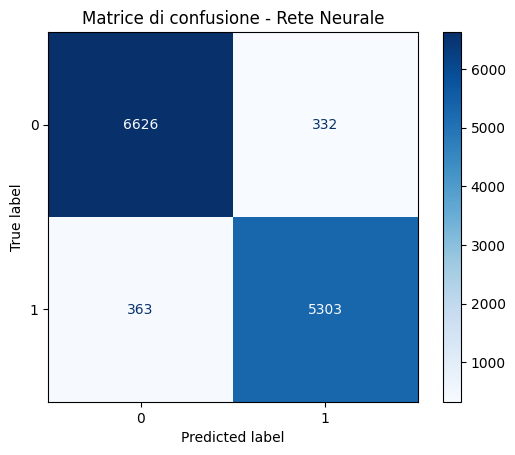

In [23]:
"""
Rete neurale
"""
nn_model = MLPClassifier(
    hidden_layer_sizes=(100,), # 1 strato nascosto con 100 neuroni
    max_iter=20,
    random_state=0,
    early_stopping=True, # ferma l'allenamento se non migliora
    verbose=True  # mostra progresso
)

# Allena la rete
nn_model.fit(X_train, y_train)

# Usa la rete per predire sul test set
y_pred_nn = nn_model.predict(X_test)

# Valuta il modello
print("\nReport classificazione (Rete Neurale):")
print(classification_report(y_test, y_pred_nn))
print("Accuratezza:", accuracy_score(y_test, y_pred_nn))

# Matrice di confusione
ConfusionMatrixDisplay.from_estimator(nn_model, X_test, y_test, cmap='Blues')
plt.title("Matrice di confusione - Rete Neurale")
plt.grid(False)
plt.show()

In [78]:
results = {
    "Logistic Regression": accuracy_score(y_test, model.predict(X_test)),
    "Logistic Regression (GridSearch)": accuracy_score(y_test, best_model.predict(X_test)),
    "SVM Lineare": accuracy_score(y_test, y_pred_linear),
    "SVM Lineare (GridSearch)": accuracy_score(y_test, y_pred_svm_grid),
    "Random Forest (base)": accuracy_score(y_test, rf_model.predict(X_test)),
    "Random Forest (ottimizzata)": accuracy_rf,
    "Rete Neurale": accuracy_score(y_test, y_pred_nn)
}

# Ordina e mostra
results = dict(sorted(results.items(), key=lambda item: item[1], reverse=True))

print("\nConfronto modelli (accuratezza test set):")
for model_name, acc in results.items():
    print(f"{model_name:<35}: {acc:.4f}")



Confronto modelli (accuratezza test set):
Logistic Regression (GridSearch)   : 0.9531
SVM Lineare                        : 0.9502
SVM Lineare (GridSearch)           : 0.9502
Logistic Regression                : 0.9466
Rete Neurale                       : 0.9449
Random Forest (base)               : 0.9430
Random Forest (ottimizzata)        : 0.9430


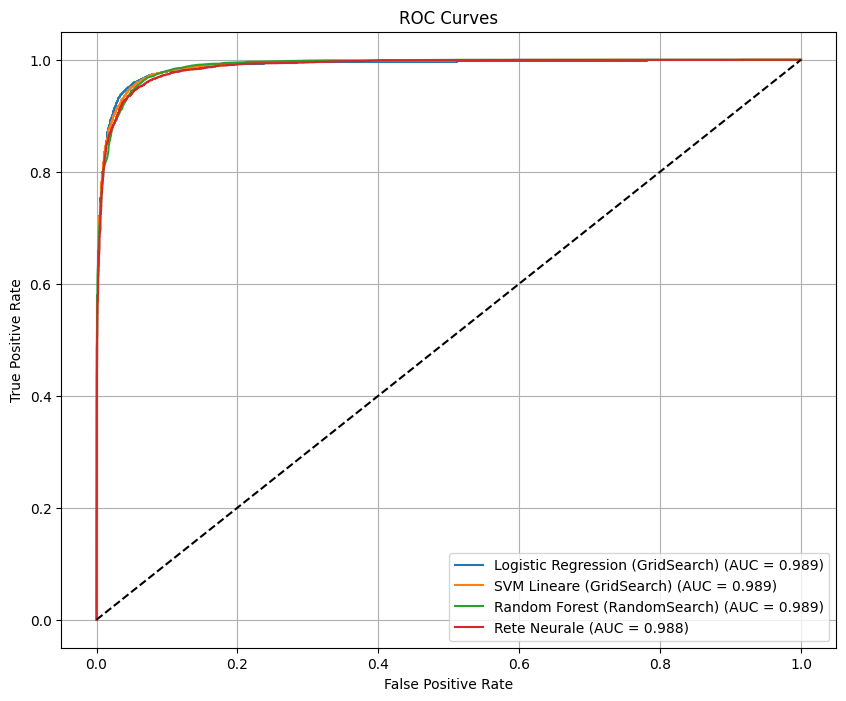

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Funzione per tracciare ROC curve di più modelli
def plot_roc_curves(models, X_test, y_test):
    plt.figure(figsize=(10,8))
    
    for name, model in models.items():
        # Per modelli con metodo predict_proba (Random Forest, Logistic Regression, MLP)
        if hasattr(model, "predict_proba"):
            y_scores = model.predict_proba(X_test)[:,1]  # probabilità classe positiva
        # Per modelli che hanno decision_function (SVM)
        elif hasattr(model, "decision_function"):
            y_scores = model.decision_function(X_test)
        else:
            print(f"{name} non ha predict_proba o decision_function, salto ROC")
            continue
        
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        auc_score = roc_auc_score(y_test, y_scores)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.3f})")
    
    # Diagonale casuale
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Definisce i modelli migliori (quelli con parametri ottimizzati)
models = {
    "Logistic Regression (GridSearch)": best_model,
    "SVM Lineare (GridSearch)": best_svm,
    "Random Forest (RandomSearch)": random_search_rf.best_estimator_,
    "Rete Neurale": nn_model
}

plot_roc_curves(models, X_test, y_test)


In [33]:
"""from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Lista di modelli e nomi (aggiungi i tuoi modelli e relative predizioni)
models_preds = [
    ("Logistic Regression", model, model.predict(X_test)),
    ("Logistic Regression (GridSearch)", best_model, best_model.predict(X_test)),
    ("SVM Lineare", svm_linear, y_pred_linear),
    ("SVM Lineare (GridSearch)", best_svm, y_pred_svm_grid),
    ("Random Forest (base)", rf_model, rf_model.predict(X_test)),
    #("Random Forest (ottimizzata)", random_search_rf.best_estimator_, random_search_rf.predict(X_test)),
    ("Rete Neurale", nn_model, y_pred_nn)
]

# Ciclo per mostrare la matrice di confusione per ciascun modello
for name, model_obj, y_pred in models_preds:
    print(f"\nMatrice di confusione per: {name}")
    ConfusionMatrixDisplay.from_estimator(model_obj, X_test, y_test, cmap='Blues')
    plt.title(f"Matrice di confusione - {name}")
    plt.grid(False)
    plt.show()"""


'from sklearn.metrics import ConfusionMatrixDisplay\nimport matplotlib.pyplot as plt\n\n# Lista di modelli e nomi (aggiungi i tuoi modelli e relative predizioni)\nmodels_preds = [\n    ("Logistic Regression", model, model.predict(X_test)),\n    ("Logistic Regression (GridSearch)", best_model, best_model.predict(X_test)),\n    ("SVM Lineare", svm_linear, y_pred_linear),\n    ("SVM Lineare (GridSearch)", best_svm, y_pred_svm_grid),\n    ("Random Forest (base)", rf_model, rf_model.predict(X_test)),\n    #("Random Forest (ottimizzata)", random_search_rf.best_estimator_, random_search_rf.predict(X_test)),\n    ("Rete Neurale", nn_model, y_pred_nn)\n]\n\n# Ciclo per mostrare la matrice di confusione per ciascun modello\nfor name, model_obj, y_pred in models_preds:\n    print(f"\nMatrice di confusione per: {name}")\n    ConfusionMatrixDisplay.from_estimator(model_obj, X_test, y_test, cmap=\'Blues\')\n    plt.title(f"Matrice di confusione - {name}")\n    plt.grid(False)\n    plt.show()'

In [34]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(
    estimators=[
        ('lr', best_model),
        ('svm', best_svm),
        #('rf', random_search_rf.best_estimator_)
    ],
    voting='hard'  # o 'soft' se i modelli supportano predict_proba
)

ensemble.fit(X_train, y_train)
print("Accuracy ensemble:", accuracy_score(y_test, ensemble.predict(X_test)))


Accuracy ensemble: 0.9519169835234474
